## triplet

In [1]:
import json

import json

with open("rag_truth_train2.json", "r") as f:
    train_data = json.load(f)
with open("rag_truth_dev.json", "r") as f:
    dev_data = json.load(f)
with open("rag_truth_test.json", "r") as f:
    test_data = json.load(f)

In [2]:
# prefixをつける
def add_prefix(data):
    for d in data:
        if d["task_type"] == "QA":
            d["ref"] = d["ref"].split(", 'passages'")[0] + "}"
        d["text"] = "Please judge the following statement as true or false based on the references above: " + d["text"]
    return data

train_data = add_prefix(train_data)
dev_data = add_prefix(dev_data)
test_data = add_prefix(test_data)

In [31]:
# task_type: QA, Data2txt, Summary
task_name = "Data2txt"
train_data = [d for d in train_data if d["task_type"] == task_name]
dev_data = [d for d in dev_data if d["task_type"] == task_name]
test_data = [d for d in test_data if d["task_type"] == task_name]

In [3]:
import random

def create_trip(data, id_list):
    trip = []
    for id in id_list:
        num = 0
        no_hal = []
        has_hal = []
        for d in data:
            if num == 6:
                num = 0
                if no_hal == [] or has_hal == []:
                    break
                '''
                for no in no_hal:
                    for has in has_hal:
                        trip.append({"anchor":ref,"positive": no, "negative": has, "labels":[0,1]})
                '''
                # シャッフル
                random.seed(id)
                no_hal = random.sample(no_hal, len(no_hal))
                has_hal = random.sample(has_hal, len(has_hal))
                
                if len(no_hal)==1 or len(no_hal)==5:
                    trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
                elif len(no_hal)==2 or len(no_hal)==4:
                    trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
                    trip.append({"anchor":ref,"positive": no_hal[1], "negative": has_hal[1], "labels":[0,1]})
                elif len(no_hal)==3:
                    trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
                    trip.append({"anchor":ref,"positive": no_hal[1], "negative": has_hal[1], "labels":[0,1]})
                    trip.append({"anchor":ref,"positive": no_hal[2], "negative": has_hal[2], "labels":[0,1]})
                no_hal = []
                has_hal = []
                break
            elif d["source_id"] == id:
                num +=1
                ref = d["ref"]
                if d["labels"] == 0:
                    no_hal.append(d["text"])
                else:
                    has_hal.append(d["text"])
        if num == 6:
            if len(no_hal)==1 or len(no_hal)==5:
                trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
            elif len(no_hal)==2 or len(no_hal)==4:
                trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
                trip.append({"anchor":ref,"positive": no_hal[1], "negative": has_hal[1], "labels":[0,1]})
            elif len(no_hal)==3:
                trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
                trip.append({"anchor":ref,"positive": no_hal[1], "negative": has_hal[1], "labels":[0,1]})
                trip.append({"anchor":ref,"positive": no_hal[2], "negative": has_hal[2], "labels":[0,1]})
    return trip

In [4]:
train_id = [d["source_id"] for d in train_data]
train_id = list(set(train_id))
dev_id = [d["source_id"] for d in dev_data]
dev_id = list(set(dev_id))
test_id = [d["source_id"] for d in test_data]
test_id = list(set(test_id))
print(len(train_id), len(dev_id), len(test_id))
train_trip = create_trip(train_data, train_id)
dev_trip = create_trip(dev_data, dev_id)
test_trip = create_trip(test_data, test_id)

2305 210 450


In [5]:
len(train_trip), len(dev_trip), len(test_trip)

(3760, 337, 633)

In [6]:
from datasets import Dataset, DatasetDict
import pandas as pd

train_df = pd.DataFrame(train_trip)
dev_df = pd.DataFrame(dev_trip)
test_df = pd.DataFrame(test_trip)

train_ds = Dataset.from_pandas(train_df)
dev_ds = Dataset.from_pandas(dev_df)
test_ds = Dataset.from_pandas(test_df)

tri_raw_datasets = DatasetDict({"train": train_ds, "dev": dev_ds, "test": test_ds})
tri_raw_datasets

DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 3760
    })
    dev: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 337
    })
    test: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 633
    })
})

In [51]:
#!huggingface-cli login

In [7]:
from transformers import AutoTokenizer, AutoModel

tri_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/RoBERTa-base")
#tri_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-hf")
#tri_tokenizer.pad_token_id = tri_tokenizer.eos_token_id
#tri_tokenizer.padding_side = "left"
#tri_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large",use_fast=False)


/gs/fs/tga-arase-student/yamada/nlp/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
tri_raw_datasets["train"][0]

{'anchor': "{'question': 'how do cold and warm fronts work'}",
 'positive': 'Please judge the following statement as true or false based on the references above: A cold front occurs when a cold air mass moves in and replaces a warmer air mass. It is a transition zone from warm air to cold air, moving from northwest to southeast. The air behind a cold front is colder and drier than the air ahead of it. The distinction between a cold front and a warm front is which one is moving and pushing the other one away. A warm front, on the other hand, occurs when a warm air mass moves in and replaces a colder air mass. When a warm or cold front stops moving, it becomes a stationary front. Once it resumes its forward motion, it becomes a warm front or a cold front again.',
 'negative': 'Please judge the following statement as true or false based on the references above: Based on the given passages, a cold front is the transition zone where a cold air mass is replacing a warmer air mass. It moves f

In [9]:
from transformers import DataCollatorWithPadding

def tri_tokenize_function(examples):
    anchor = tri_tokenizer(examples["anchor"], truncation=True,max_length=512,padding="max_length")
    positive = tri_tokenizer(examples["positive"], truncation=True,max_length=512,padding="max_length")
    negative = tri_tokenizer(examples["negative"], truncation=True,max_length=512,padding="max_length")

    return {
        "anchor_input_ids": anchor["input_ids"],
        "anchor_attention_mask": anchor["attention_mask"],
        "positive_input_ids": positive["input_ids"],
        "positive_attention_mask": positive["attention_mask"],
        "negative_input_ids": negative["input_ids"],
        "negative_attention_mask": negative["attention_mask"],
    }

tri_tokenized_datasets = tri_raw_datasets.map(tri_tokenize_function, batched=True)
tri_tokenized_datasets = tri_tokenized_datasets.remove_columns(["anchor", "positive", "negative"])
#tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
#tri_tokenized_datasets.set_format("torch")
tri_data_collator = DataCollatorWithPadding(tokenizer=tri_tokenizer)

2025-02-13 12:18:10.681155: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 12:18:11.093340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-13 12:18:11.285922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-13 12:18:11.286376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 12:18:11.637669: I tensorflow/core/platform/cpu_feature_gua

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/633 [00:00<?, ? examples/s]

In [10]:
from transformers import DataCollatorWithPadding
from torch.nn.utils.rnn import pad_sequence
import torch

class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        # features の例: [{'anchor_input_ids': ..., 'anchor_attention_mask': ..., ...}, ...]
        
        # データのリストを作成
        anchor_ids = [torch.tensor(x['anchor_input_ids']) for x in features]
        positive_ids = [torch.tensor(x['positive_input_ids']) for x in features]
        negative_ids = [torch.tensor(x['negative_input_ids']) for x in features]
        
        anchor_mask = [torch.tensor(x['anchor_attention_mask']) for x in features]
        positive_mask = [torch.tensor(x['positive_attention_mask']) for x in features]
        negative_mask = [torch.tensor(x['negative_attention_mask']) for x in features]
        
        # パディング処理
        anchor_ids = pad_sequence(anchor_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        positive_ids = pad_sequence(positive_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        negative_ids = pad_sequence(negative_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        
        anchor_mask = pad_sequence(anchor_mask, batch_first=True, padding_value=0)
        positive_mask = pad_sequence(positive_mask, batch_first=True, padding_value=0)
        negative_mask = pad_sequence(negative_mask, batch_first=True, padding_value=0)

        # ラベルを作成
        labels = [torch.tensor(x['labels']) for x in features]
        
        
        # バッチ辞書を作成
        batch = {
            "input_ids": [anchor_ids, positive_ids, negative_ids],
            "attention_mask": [anchor_mask, positive_mask, negative_mask],
            "labels": labels
        }
        
        return batch


tri_data_collator = CustomDataCollator(tokenizer=tri_tokenizer)

In [11]:
from transformers import AutoModel


base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")
#base_model = AutoModel.from_pretrained("meta-llama/Llama-2-13b-hf",device_map="auto")
#base_model = AutoModel.from_pretrained("vinai/bertweet-large")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/RoBERTa-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import torch

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
base_model.to(device)
device

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

device(type='cuda')

In [13]:
import torch
import torch.nn as nn
from transformers.modeling_outputs import ModelOutput
import os


class TripletModel(nn.Module):
    def __init__(self, base_model, loss_function, question_encoder=None, generator=None):
        super(TripletModel, self).__init__()
        self.base_model = base_model
        #self.triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(base_model.config.hidden_size * 2, 2)  # ラベル予測用の分類層
        #self.classifier = nn.Linear(base_model.config.hidden_size, 2)
        #self.classifier = nn.Linear(128 * 2, 2)
        # self.classification_loss_fn = nn.CrossEntropyLoss()  # ラベル予測の損失関数
        self.loss_function = loss_function
        self.question_encoder = question_encoder
        self.generator = generator

    def forward(
        self,
        input_ids,
        attention_mask = None,
        labels = None
    ):
        
        anchor_input_ids = input_ids[0]
        positive_input_ids = input_ids[1]
        negative_input_ids = input_ids[2]
        anchor_attention_mask = attention_mask[0]
        positive_attention_mask = attention_mask[1]
        negative_attention_mask = attention_mask[2]


        anchor_output = self.base_model(input_ids=anchor_input_ids, attention_mask=anchor_attention_mask,return_dict=True)[1]
        positive_output = self.base_model(input_ids=positive_input_ids, attention_mask=positive_attention_mask,return_dict=True)[1]
        negative_output = self.base_model(input_ids=negative_input_ids, attention_mask=negative_attention_mask,return_dict=True)[1]
        
        
        #print(len(anchor_output),len(positive_output),len(negative_output))

        anchor_output = self.dropout(anchor_output)
        positive_output = self.dropout(positive_output)
        negative_output = self.dropout(negative_output)

        # ラベル予測の出力
        positive_logits = self.classifier(torch.cat([anchor_output, positive_output], dim=1))
        negative_logits = self.classifier(torch.cat([anchor_output, negative_output], dim=1))
        #positive_logits = self.classifier(positive_output)
        #negative_logits = self.classifier(negative_output)

        a = 0.0
        #loss = self.loss_function(anchor_output, positive_output, negative_output, positive_logits, negative_logits)
        classification_loss, triplet_loss=self.loss_function(anchor_output, positive_output, negative_output, positive_logits, negative_logits)
        loss = classification_loss + triplet_loss
        
        #return ModelOutput(logits=[positive_logits, negative_logits], loss=loss,classification_loss=classification_loss,triplet_loss=triplet_loss)
        return ModelOutput(logits=[positive_logits, negative_logits],loss=loss)
    
    def save_pretrained(self, save_directory):
        """
        モデル全体とサブモジュールを保存するカスタムメソッド
        """
        os.makedirs(save_directory, exist_ok=True)

        # サブモジュールの保存
        if self.question_encoder is not None:
            self.question_encoder.save_pretrained(os.path.join(save_directory, "question_encoder"))
        if self.generator is not None:
            self.generator.save_pretrained(os.path.join(save_directory, "generator"))

        # モデル全体の重みを保存
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))
        
    @classmethod
    def from_pretrained(cls, save_directory):
        """
        保存済みモデルをロードするカスタムメソッド
        """
        question_encoder = None
        generator = None

        # サブモジュールのロード
        if os.path.exists(os.path.join(save_directory, "question_encoder")):
            question_encoder = AutoModel.from_pretrained(os.path.join(save_directory, "question_encoder"))
        if os.path.exists(os.path.join(save_directory, "generator")):
            generator = AutoModel.from_pretrained(os.path.join(save_directory, "generator"))

        # モデル全体の重みをロード
        model = cls(question_encoder=question_encoder, generator=generator)
        model.load_state_dict(torch.load(os.path.join(save_directory, "pytorch_model.bin")))

        return model


In [14]:
import torch.nn.functional as F
clas_list = []
trip_list = []
def triplet_loss(anchor_output, positive_output, negative_output, positive_logits, negative_logits):
    # ラベル予測の損失計算
    positive_targets = torch.zeros(positive_output.size(0), dtype=torch.long).to(device)  # ラベル1 (positive)
    negative_targets = torch.ones(negative_output.size(0), dtype=torch.long).to(device)
    positive_loss = nn.CrossEntropyLoss()(positive_logits, positive_targets)
    negative_loss = nn.CrossEntropyLoss()(negative_logits, negative_targets)

    # ラベル予測の損失を平均
    classification_loss = (positive_loss + negative_loss) / 2.0

    # トリプレット損失の計算
    #triplet_loss = nn.TripletMarginLoss(margin=1, p=2)(anchor_output, positive_output, negative_output)
    triplet_loss_fn = (nn.TripletMarginWithDistanceLoss(margin=1.0,distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)))
    triplet_loss = triplet_loss_fn(anchor_output, positive_output, negative_output)
    # 最終損失
    total_loss = classification_loss + triplet_loss 
    #return total_loss
    trip_list.append(triplet_loss)
    clas_list.append(classification_loss)
    return classification_loss, triplet_loss

In [15]:
import torch
import numpy as np

def compute_tri_metrics(eval_pred):
    #print("aa")
    # モデルの出力から損失と logits を取得
    logits,labels= eval_pred
    
    # ロジットのサイズに合わせて推論を行う
    positive_logits = torch.tensor(logits[0])
    negative_logits = torch.tensor(logits[1])
    #positive_logits = torch.tensor(logits[0][0])
    #negative_logits = torch.tensor(logits[0][1])



    # ラベル予測
    positive_preds = torch.argmax(positive_logits, dim=1)
    negative_preds = torch.argmax(negative_logits, dim=1)

    # 正解と予測ラベルの一致数
    correct_positive = (positive_preds == 0).sum().item()
    correct_negative = (negative_preds == 1).sum().item()
    
    # ラベルの数
    total_samples = positive_preds.size(0) + negative_preds.size(0)
    
    # PositiveとNegativeの予測数
    positive_preds_num = (positive_preds == 1).sum().item()
    negative_preds_num = (negative_preds == 1).sum().item()
    positive_num = positive_preds.size(0)
    negative_num = negative_preds.size(0)

    #print(negative_preds_num,positive_preds_num,negative_num)

    # Precision, Recall, F1の計算
    precision = negative_preds_num / (positive_preds_num + negative_preds_num) if (positive_preds_num + negative_preds_num) > 0 else 0
    recall = negative_preds_num / negative_num if negative_num > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # 平均損失と正解率の計算
    #avg_loss = loss.item() if loss is not None else 0
    accuracy = (correct_positive + correct_negative) / total_samples
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }
    


In [16]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from collections import defaultdict


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    positive_logits = torch.tensor(logits[0])
    negative_logits = torch.tensor(logits[1])
    positive_preds = torch.argmax(positive_logits, dim=1)
    negative_preds = torch.argmax(negative_logits, dim=1)
    
    predictions = positive_preds.tolist() + negative_preds.tolist()
    num = defaultdict(lambda: 0)
    for pre in predictions:
        num[pre] += 1
    print(num)
    labels = [0] * len(positive_preds) + [1] * len(negative_preds)
    num2 = defaultdict(lambda: 0)
    for pre in labels:
        num2[pre] += 1
    print(num2)

    # accuracy と f1 score を計算
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions)
    precision = precision_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return {"accuracy": accuracy, "recall": recall, "precision": precision, "f1": f1}

In [17]:
from transformers import TrainingArguments
from transformers import Trainer

from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding
import torch
#from models_rob import TripletModel

"""
base_model = AutoModel.from_pretrained("FacebookAI/roberta-base")
# モデルとトークナイザーを読み込む
name = "./0102_triplet_rob"
tri_model = TripletModel.from_pretrained(base_model, triplet_loss, name)
#tokenizer = AutoTokenizer.from_pretrained(name)

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tri_model.to(device)
"""


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="steps",  
    save_steps=10000,
    learning_rate=5e-6,# 1e-6
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16 = True,
    gradient_accumulation_steps=3,
    logging_dir="./logs",
    remove_unused_columns=False,
    report_to="tensorboard",
)

tri_model = TripletModel(base_model, triplet_loss)
#triplet_loss_logger = TripletLossLogger()
trainer = Trainer(
    model=tri_model,
    args=training_args,
    train_dataset=tri_tokenized_datasets["train"],
    eval_dataset=tri_tokenized_datasets["dev"],
    data_collator=tri_data_collator,
    tokenizer=tri_tokenizer,
    compute_metrics=compute_tri_metrics,
    #compute_metrics=compute_metrics,

)

/gs/fs/tga-arase-student/yamada/nlp/lib64/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
trainer.evaluate()

{'eval_loss': 1.6933441162109375,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.49851632047477745,
 'eval_recall': 0.005934718100890208,
 'eval_precision': 0.4,
 'eval_f1': 0.011695906432748539,
 'eval_runtime': 4.8403,
 'eval_samples_per_second': 69.624,
 'eval_steps_per_second': 17.561}

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Recall,Precision,F1
0,1.497100,1.207629,0.002400,0.695846,0.724036,0.685393,0.704185
1,1.152500,1.117136,0.002400,0.727003,0.813056,0.693671,0.748634
3,1.004000,1.043206,0.002400,0.732938,0.845697,0.690073,0.760000
4,0.949000,1.178038,0.002400,0.700297,0.928783,0.637475,0.756039
6,0.872800,1.100712,0.002400,0.725519,0.896142,0.668142,0.765526
7,0.843500,1.070615,0.002400,0.743323,0.884273,0.689815,0.775033
9,0.792100,1.118366,0.002400,0.732938,0.910979,0.671772,0.773300


TrainOutput(global_step=3130, training_loss=0.9897091557804388, metrics={'train_runtime': 936.4163, 'train_samples_per_second': 40.153, 'train_steps_per_second': 3.343, 'total_flos': 0.0, 'train_loss': 0.9897091557804388, 'epoch': 9.98936170212766})

In [20]:
trainer.evaluate(eval_dataset=tri_tokenized_datasets["test"])

{'eval_loss': 1.1910415887832642,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.7116903633491312,
 'eval_recall': 0.9146919431279621,
 'eval_precision': 0.650561797752809,
 'eval_f1': 0.7603414313854235,
 'eval_runtime': 5.2242,
 'eval_samples_per_second': 121.166,
 'eval_steps_per_second': 30.435,
 'epoch': 9.98936170212766}

In [21]:
def create_dev_task(name):
    dev_data2 = [d for d in test_data if d["task_type"] == name]
    dev_id2 = [d["source_id"] for d in dev_data2]
    dev_id2 = list(set(dev_id2))
    dev_trip2 = create_trip(dev_data2, dev_id2)
    dev_df2 = pd.DataFrame(dev_trip2)
    dev_ds2 = Dataset.from_pandas(dev_df2)
    tri_tokenized_datasets_task = dev_ds2.map(tri_tokenize_function, batched=True)
    tri_tokenized_datasets_task = tri_tokenized_datasets_task.remove_columns(["anchor", "positive", "negative"])
    tri_tokenized_datasets_task.set_format("torch")
    return tri_tokenized_datasets_task

In [22]:
dev_qa = create_dev_task("QA")
trainer.evaluate(eval_dataset=dev_qa)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

/tmp/24138.1.interactive/ipykernel_2222067/200384749.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_ids = [torch.tensor(x['anchor_input_ids']) for x in features]
/tmp/24138.1.interactive/ipykernel_2222067/200384749.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_ids = [torch.tensor(x['positive_input_ids']) for x in features]
/tmp/24138.1.interactive/ipykernel_2222067/200384749.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_ids = [torch.tensor(x['negative_input_ids']) for x in features]
/tmp/24138.

{'eval_loss': 1.0711263418197632,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.7266666666666667,
 'eval_recall': 0.8866666666666667,
 'eval_precision': 0.6717171717171717,
 'eval_f1': 0.7643678160919541,
 'eval_runtime': 1.1535,
 'eval_samples_per_second': 130.034,
 'eval_steps_per_second': 32.942,
 'epoch': 9.98936170212766}

In [23]:
dev_d2t = create_dev_task("Data2txt")
trainer.evaluate(eval_dataset=dev_d2t)

Map:   0%|          | 0/291 [00:00<?, ? examples/s]

/tmp/24138.1.interactive/ipykernel_2222067/200384749.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_ids = [torch.tensor(x['anchor_input_ids']) for x in features]
/tmp/24138.1.interactive/ipykernel_2222067/200384749.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_ids = [torch.tensor(x['positive_input_ids']) for x in features]
/tmp/24138.1.interactive/ipykernel_2222067/200384749.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_ids = [torch.tensor(x['negative_input_ids']) for x in features]
/tmp/24138.

{'eval_loss': 0.8725352883338928,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.802405498281787,
 'eval_recall': 0.9243986254295533,
 'eval_precision': 0.7430939226519337,
 'eval_f1': 0.8238897396630935,
 'eval_runtime': 2.2254,
 'eval_samples_per_second': 130.766,
 'eval_steps_per_second': 32.804,
 'epoch': 9.98936170212766}

In [24]:
dev_sum = create_dev_task("Summary")
trainer.evaluate(eval_dataset=dev_sum)

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

/tmp/24138.1.interactive/ipykernel_2222067/200384749.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_ids = [torch.tensor(x['anchor_input_ids']) for x in features]
/tmp/24138.1.interactive/ipykernel_2222067/200384749.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_ids = [torch.tensor(x['positive_input_ids']) for x in features]
/tmp/24138.1.interactive/ipykernel_2222067/200384749.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_ids = [torch.tensor(x['negative_input_ids']) for x in features]
/tmp/24138.

{'eval_loss': 1.7708507776260376,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.5625,
 'eval_recall': 0.921875,
 'eval_precision': 0.5363636363636364,
 'eval_f1': 0.6781609195402298,
 'eval_runtime': 1.4686,
 'eval_samples_per_second': 130.739,
 'eval_steps_per_second': 32.685,
 'epoch': 9.98936170212766}

In [37]:
name = "./0102_triplet_rob"
trainer.save_model(name)
trainer.save_state()
tri_model.save_pretrained(name)

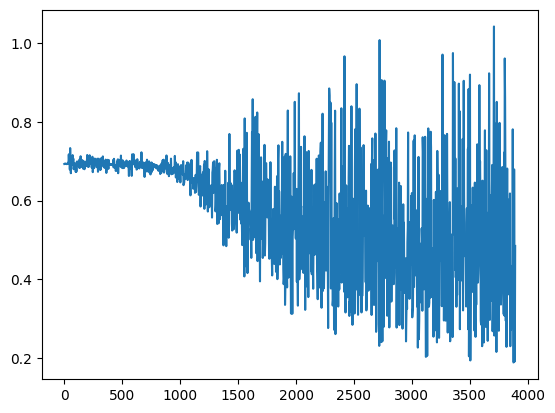

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# 勾配を計算グラフから切り離してNumPy配列に変換
clas_list = [tensor.detach().cpu().numpy() for tensor in clas_list]

x = np.arange(0, len(clas_list), len(clas_list) // 1000)
clas_list = np.array(clas_list)

plt.plot(x, clas_list[x])
plt.show()



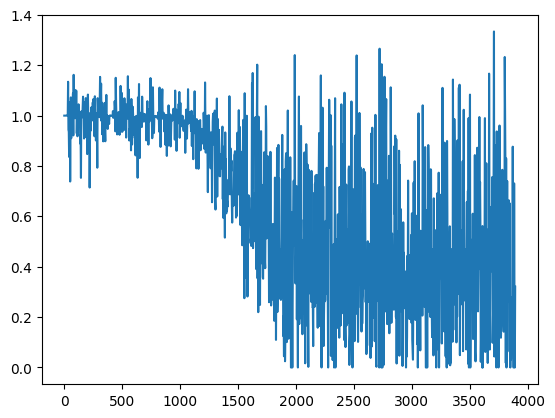

In [51]:
import matplotlib.pyplot as plt

trip_list = [tensor.detach().cpu().numpy() for tensor in trip_list]

x = np.arange(0, len(trip_list), len(trip_list) // 1000)
trip_list = np.array(trip_list)
plt.plot(x, trip_list[x])
plt.show()

In [23]:
torch.cuda.empty_cache() 
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wed Nov  6 13:19:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100                    On  | 00000000:04:00.0 Off |                    0 |
| N/A   29C    P0             152W / 699W |  50200MiB / 95830MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### 色々検証

In [29]:
import pandas as pd

# 予測結果をDataFrameに変換
predictions_df = pd.DataFrame(predictions.predictions[1])

predictions_df['label_ids'] = 1

# CSVファイルとして保存
predictions_df.to_csv("predictions_1.csv", index=False)

In [30]:
import pandas as pd

# CSVファイルを読み込む
df1 = pd.read_csv("predictions.csv")
df2 = pd.read_csv("predictions_1.csv")

# 縦に結合
combined_df = pd.concat([df1, df2], ignore_index=True)

# 結合したデータをCSVとして保存
combined_df.to_csv("predictions_2.csv", index=False)


In [ ]:
trip_list = [x.item() for x in trip_list]
clas_list = [x.item() for x in clas_list]

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(0,len(clas_list),len(clas_list)//1000)
clas_list = np.array(clas_list)
trip_list = np.array(trip_list)
plt.plot(x,clas_list[x])

In [ ]:
plt.plot(x,trip_list[x])

In [ ]:
plt.plot(x,trip_list[x]+clas_list[x])

In [27]:
print(len(predictions.predictions[0]))  # 出力の形状を確認
print(len(predictions.label_ids[0]))

2509
1255


In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# CSVファイルを読み込む
df = pd.read_csv("predictions_2.csv")

# クラスラベルを予測
df['predicted_label'] = np.where(df["0"] > df["1"], 0, 1)

# 正解ラベルと予測ラベルを取得
true_labels = df['label_ids']  # 正解ラベルの列名を指定
predicted_labels = df['predicted_label']

# 各評価指標を計算
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# 結果を表示
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.6853
Precision: 0.6286
Recall: 0.9059
F1 Score: 0.7422
